<a href="https://colab.research.google.com/github/AlexeyEvzrezov/DS_projects/blob/master/car_price_prediction/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение рыночной стоимости автомобилей по их характеристикам

В настоящей работе реализована модель для определения рыночной стоимости автомобилей на основе исторических данных о технических характеристиках, комплектации и ценах автомобилей.  

Модель необходима для использования в приложении сервиса по продаже автомобилей для привлечения новых клиентов.  
В приложении можно быстро узнать рыночную стоимость своего автомобиля.

## Содержание
- [Описание данных](#0)
1. [Загрузка и подготовка данных](#1)    
2. [Обучение и настройка моделей](#2)    
3. [Анализ скорости работы и качества моделей](#3)
- [Выводы](#5)

<a id="0"></a> 
## Описание данных
Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

<a id="1"></a> 
## Загрузка и подготовка данных

In [ ]:
! pip install catboost

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import time

import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на них.

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')                 

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим типы данных и количество пропусков.

In [5]:
pd.concat([df.dtypes.sort_values(), 
           df.isna().sum(), 
           df.isna().mean(),
          ], 
          axis=1,
          keys=['DType', 'NA count', 'NA ratio']).T

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
DType,int64,int64,int64,int64,int64,int64,int64,object,object,object,object,object,object,object,object,object
NA count,0,0,0,0,0,0,0,0,37490,19833,19705,32895,0,71154,0,0
NA ratio,0,0,0,0,0,0,0,0,0.105794,0.0559671,0.0556059,0.092827,0,0.200791,0,0


Посмотрим на статистики по числовым признакам.

In [6]:
df.describe( )

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Посмотрим на уникальные значения категориальных признаков.

In [7]:
cat_features = ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType', 'PostalCode']

for feature in cat_features:
    print(df[feature].unique())

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'm

Отметим следующее:
- Очевидно, что 'petrol' и 'gasoline' обозначают одно и то же.
- Дата скачивания анкеты из базы `DateCrawled` не несет полезной информации
- Полезность значений `DateCreated` и `LastSeen` также можно поставить под сомнение (отдельно проверим их диапазон)
- Среди значений `RegistrationMonth` имеются нули (при остальных от 1 до 12). Необходимость этого признака при наличии `RegistrationYear` также можно поставить под сомнение
- Имеются подозрительные значения признаков `RegistrationYear` (min 1000), `Price` (min 0.0), `Power` (min 0.0)
- Количество фото `NumberOfPictures` на всем объектам равно нулю, данный признак не информативен
- Пропусков относительно немного, в пределах 10%, за исключением порядка 20% по признаку `NotRepaired`

Учитывая тот факт, что модель будет использоваться в ***приложении для оценки рыночной стоимости по вводимым пользователями характеристикам***, примем соответствующие решения по дальнейшей обработке данных:
- Удалим все пропуски. Данных довольно много и модели не придется работать с пропусками в дальнейшем (исходим из того, что список вводимых пользователями характеристик является обязательным)
- Удалим выбросы аномальные значения. Наша задача - обеспечить подавляющее большинство пользовтелей приложения достоверной оценкой стоимости на основе вводимых ими характеристик, а не восстанавливать цены по содержанию объявлений. Такм образом, мы будем обучать модели только на таких данных, которые отражают подавляющее большинство реальных ситуаций.

Перейдем непосредственно к обработке данных.  
Приведем значения 'gasoline' и 'petrol' к единой форме 'petrol'. 

In [8]:
df.FuelType = df.FuelType.str.replace( 'gasoline',  'petrol')

Проверим диапазоны значений `DateCreated` и `LastSeen`.

In [9]:
_ = df[['DateCreated', 'LastSeen']].astype('datetime64')
_.max() - _.min() 

DateCreated   759 days 00:00:00
LastSeen       33 days 00:43:43
dtype: timedelta64[ns]

Как видим все пользователи проявляли активность в пределах 33-х дней. Вряд ли этот признак что-то скажет нам о цене автомобиля.  
Даты создания объявления находятся в гораздо более широком диапазоне значений. Можно предположить, что в какой-то степени заявляемые цены могут зависеть от дат размещения, при этом мы считаем данный признак несущественным.

Проверим наличие дубликатов и удалим их.

In [10]:
print('Дубликатов в исходных данных:', df.duplicated().sum())
df = df.drop_duplicates()

Дубликатов в исходных данных: 4


Сохраним отдельно неинформативные и несущественные признаки и создадим новую таблицу без них.

In [11]:
not_suff = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 
            'NumberOfPictures', 'LastSeen']
df_cleaned = df.drop(not_suff, axis=1)

Легко убедиться, что после удаления несущественных признаков дубликатов стало более двадцати тысяч. Эти дубликаты удалять не будем, т.к. скорее всего мы все же имеем дело с различными объектами, по которым значения оставшихся признаков просто совпадают. Таким образом, не будем уменьшать влияние данных объектов.

Перед удалением пропусков проверим, как это скажется на размере выборки.

In [12]:
nans10 = ['VehicleType', 'Gearbox', 'Model', 'FuelType']                        # признаки с пропусками в пределах 10%

for cols in nans10, nans10 + ['NotRepaired']:
    print(f'Остаток выборки после удаления пропусков {cols}:\n',
          df_cleaned.dropna(subset=cols).shape[0] / df.shape[0]) 

Остаток выборки после удаления пропусков ['VehicleType', 'Gearbox', 'Model', 'FuelType']:
 0.8017778279457621
Остаток выборки после удаления пропусков ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
 0.693663313250462


Проверим также, как часто повторяются значения имеющих пропуски признаков для отдельных моделей.

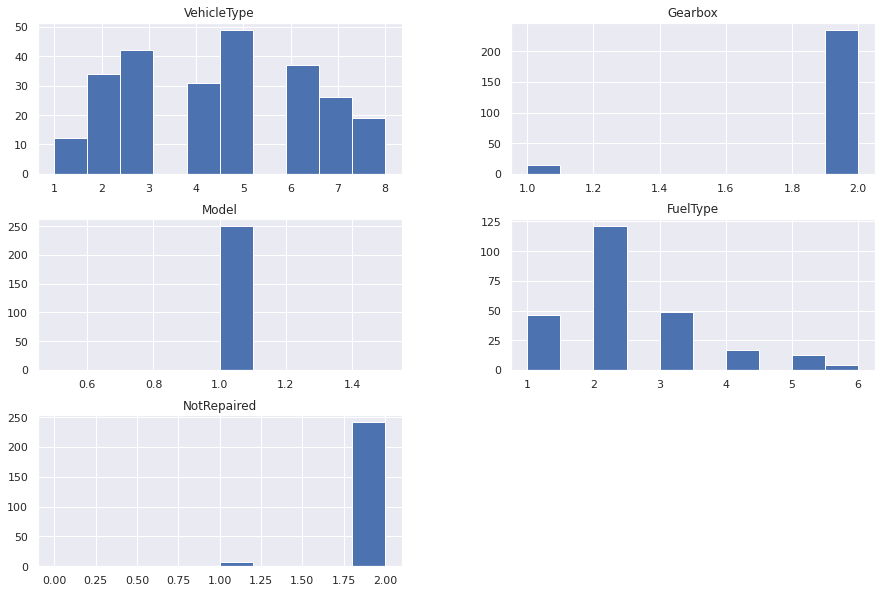

In [13]:
df_cleaned.groupby('Model')[nans10 + ['NotRepaired']].nunique().hist(figsize=(15, 10));

Как видно из графиков, вряд ли мы можем уверенно заполнить имеющиеся пропуски 
по модели автомобиля.  
Таким образом, принимаем окончательное решение об удалении всех пропусков.

In [14]:
df_cleaned = df_cleaned.dropna()

Посмотрим на распределение числовых признаков.

In [15]:
num_features = list(set(df_cleaned.columns) - set(cat_features))

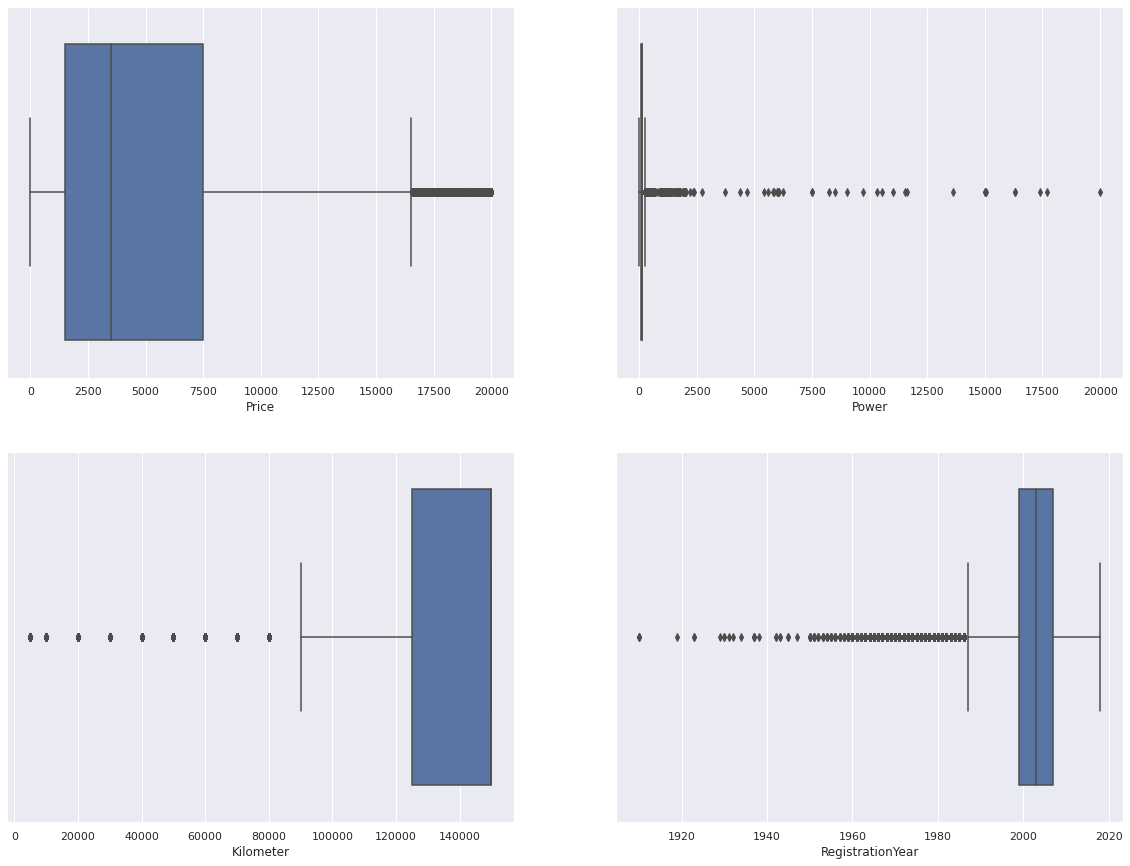

In [16]:
plt.figure(figsize=(20, 15))

for i, feature in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=feature, data=df_cleaned)
    
plt.show()

Удалим редкие и аномальные значения мощности. Соответствующий диапазон (30, 290) выберем вручную исходя из реальных данных. Точечная проверка мощности за пределами выбранного диапазона подтверждает некорректность значений для указанных моделей.

In [17]:
df_cleaned = df_cleaned.query('30 < Power < 290')

Посмотрим еще раз на статистики.

In [18]:
df_cleaned.describe()

,Price,RegistrationYear,Power,Kilometer,PostalCode
count,232871.000000,232871.000000,232871.000000,232871.000000,232871.000000
mean,5149.782103,2003.076107,120.502308,127123.342967,51691.003732
std,4675.873220,6.020957,48.121889,37019.004462,25824.962252
min,0.000000,1930.000000,31.000000,5000.000000,1067.000000
25%,1500.000000,1999.000000,81.000000,125000.000000,31178.500000
50%,3500.000000,2003.000000,115.000000,150000.000000,51063.000000
75%,7500.000000,2007.000000,150.000000,150000.000000,72518.000000
max,20000.000000,2018.000000,289.000000,150000.000000,99998.000000


Как видим, после удаления некоторых аномальных значений часть прочих аномалий  отбросилась сама собой, что указывает на корректность наших действий.

Посмотрим теперь на цены и год регистрации автомобилей в контексте пробега и наличия ремонта.

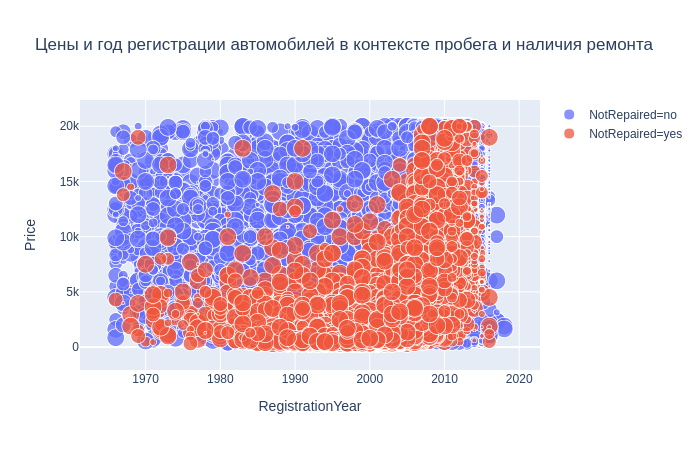

In [24]:
fig = px.scatter(df_cleaned, 
                 y='Price', 
                 x='RegistrationYear', 
                 color='NotRepaired', 
                 opacity=.75,
                 size='Kilometer', 
                 size_max=10, 
                 title='Цены и год регистрации автомобилей в контексте пробега и наличия ремонта')
fig.show('png')

Глядя на диаграмму, оставим наиболее внятные и массовые данные об автомобилях с ценой более 300 евро и годом регистрации от 1960.

In [20]:
df_cleaned = df_cleaned.query('Price > 300 and RegistrationYear > 1965')

Убедимся, что мы имеем достаточное количество данных после всех удалений.

In [21]:
df_cleaned.shape

(225450, 11)

Для общего представления посмотрим на средний уровень цен по брендам.

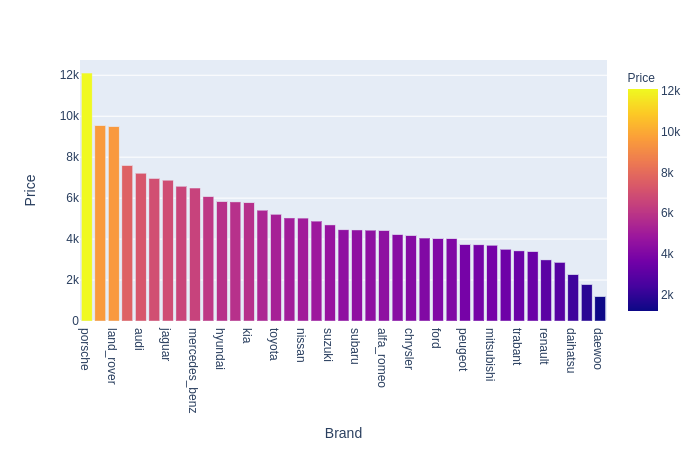

In [25]:
_ = df_cleaned.groupby('Brand').Price.mean().sort_values(ascending=False)
fig = px.bar(_.reset_index(), x='Brand', y='Price', color='Price')
fig.show('png')

Перед тем как приступить к обучению, приведем категориальные признаки к соответствующему типу и разделим данные на выборки.

In [ ]:
df_cleaned[cat_features] = df_cleaned[cat_features].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(['Price'], 
                                                                    axis=1), 
                                                    df_cleaned.Price, 
                                                    test_size=0.25, 
                                                    random_state=0)

<a id="2"></a> 
## 2. Обучение и настройка моделей

Посмотрим для начала, как работает константная модель.  
Т.к. нашей целевой метрикой является RMSE, будем использовать среднее арифметическое значение для оценки.

In [ ]:
print('RMSE константной модели:')
mean_squared_error(y_test, [y_train.mean()] * y_test.shape[0]) ** .5

RMSE константной модели:


4659.680552962028

Теперь перейдем к обучению моделей.
Будем применять градиентный бустинг над деревьями с использованием библиотек LightGBM, CatBoost и XGBoost.
Для работы с XGBoost напишем функцию для порядкового кодирования категориальных данных.

In [ ]:
def encode(X):
    """
    Осуществляет порядковое кодирование Х
    """
    enc = OrdinalEncoder()
    X[cat_features] = enc.fit_transform(X[cat_features])
    return X

Напишем функцию для оптимизации параметров моделей.  
Будем придерживаться следующей стратегии:
- зафиксируем небольшое число деревьев, чтобы алгоритм быстро обучался, подбирая под него другие параметры;
- после выбора этих параметров на кросс-валидации, оставив их неизменными, проведем еще один цикл для итогового выбора уже увеличенного количества деревьев и подходящего значения learning rate.

In [ ]:
def model_tuning(model, 
                 X, 
                 y, 
                 param_grid_first, 
                 param_grid_final,
                 cv=3, 
                 scoring='neg_root_mean_squared_error'):
    """
    Реализует двухэтапный GridSearchCV по заданным словарям параметров
    """

    first_grid = GridSearchCV(model, 
                              param_grid_first, 
                              cv=cv, 
                              scoring=scoring)
    try:
        first_grid.fit(X, y)
    except ValueError:
        first_grid.fit(encode(X.copy()), y)    

    second_grid = GridSearchCV(model.set_params(**first_grid.best_params_), 
                               param_grid_final, 
                               cv=cv, 
                               scoring='neg_root_mean_squared_error')
    try: 
        second_grid.fit(X, y)
    except ValueError:
        second_grid.fit(encode(X.copy()), y)         

    print('Mean cross-validated RMSE:', -second_grid.best_score_)

    return model.set_params(**second_grid.best_params_)

Перейдем непосредственно к подбору параметров.
Для всех моделей явно зададим отдельные одинаковые параметры на каждом этапе перебора, не меняя заданные по умолчанию.

In [ ]:
init_estimators = 10 
param_grid_first = {
                    'num_leaves': [800, 1500, 3000],
                    }
param_grid_first_xgbr = {
                    'max_leaves': [800, 1500, 3000],
                    }
param_grid_final = {'learning_rate': [.1, .02],
                    'n_estimators': [100, 250],
                    }   

In [ ]:
lgbr = LGBMRegressor(n_estimators=init_estimators, 
                     random_state=0
                     )  
cbr = CatBoostRegressor(n_estimators=init_estimators,
                        cat_features=cat_features, 
                        grow_policy='Lossguide',
                        verbose=0,
                        random_state=0
                        )
xgbr = XGBRegressor(objective='reg:squarederror',
                    n_estimators=init_estimators, 
                    grow_policy='lossguide',
                    random_state=0
                    )

models = {'xgbr': xgbr, 'lgbr': lgbr, 'cbr': cbr}

In [ ]:
%%time
for name, model in models.items():
    print('-' * 60)
    print(name + '...')
    if name == 'xgbr':
        first = param_grid_first_xgbr
    else:
        first = param_grid_first   
    models[name] = model_tuning(model, 
                                X_train, 
                                y_train, 
                                first, 
                                param_grid_final)
    print('-' * 60)

------------------------------------------------------------
xgbr...
Mean cross-validated RMSE: 1725.914523397436
------------------------------------------------------------
------------------------------------------------------------
lgbr...
Mean cross-validated RMSE: 1491.3185715233474
------------------------------------------------------------
------------------------------------------------------------
cbr...
Mean cross-validated RMSE: 1568.5546899838962
------------------------------------------------------------
CPU times: user 10min 7s, sys: 1min 1s, total: 11min 9s
Wall time: 10min 6s


<a id="3"></a> 
## 3. Анализ скорости работы и качества моделей

Напишем функцию для расчета требуемых показателей:
- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
def timer(model):
    """
    Возвращает словарь, содержащий RMSE, время предсказания и время обучения
    переданной модели.
    """

    global X_train, y_train, X_test, y_test

    t0 = time.time()
    try: 
        model.fit(X_train, y_train)
    except ValueError:
        model.fit(encode(X_train.copy()), y_train)  
    t_learn = time.time() - t0

    t0 = time.time()
    try: 
        y_pred = model.predict(X_test)
    except ValueError:
        y_pred = model.predict(encode(X_test.copy()))     
    t_pred = time.time() - t0

    rmse = mean_squared_error(y_test, y_pred) ** .5

    return {'rmse': rmse, 't_pred': t_pred, 't_learn': t_learn}

Рассчитаем показатели для каждой модели.

In [ ]:
_ = []
for name, model in models.items():
    a = timer(model)
    temp = pd.DataFrame(a.values(), index=a.keys(), columns=[name])
    _.append(temp)

Сведем результаты в таблицу.

In [ ]:
res = pd.concat(_, axis=1)
res

,xgbr,lgbr,cbr
rmse,1766.636895,1443.551861,1540.654099
t_pred,0.556129,10.672118,0.407438
t_learn,15.245751,35.352536,7.275596


Как видим, наименьшую ошибку показывает LGBMRegressor, при этом данная модель работает ощутимо медленнее других, что особенно заметно на скорости предсказания. На этом фоне можно выделить CatBoostRegressor c наиболее быстрым времением выполнения и приемлемым значением ошибки.

<a id="5"></a> 
## Выводы

В рамках данной работы мы построили модели градиентного бустинга над деревьями для оценки рыночной стоимости автомобилей по их характеристикам.

Мы изучили и обработали исторические данные из базы объявлений о продаже автомобилей и на их основе обучили модели из библиотек LightGBM, CatBoost и XGBoost, выполнив подбор гиперпараметров на кросс-валидации.

Нами было проведено сравнение моделей по качеству и скорости предсказания, а также по времени обучения.  
В резульате наименьшее значение RMSE (1443) показала модель, реализованная средствами библиотеки LightGBM, при этом время ее работы оказалось ощутимо дольше других, что особенно заметно на скорости предсказания. На этом фоне мы выделили библиотеку CatBoost c наиболее быстрым времением выполнения и приемлемым значением ошибки.